<a href="https://colab.research.google.com/github/emily2925/google_ecommerce_data_project/blob/main/kmean_%E6%89%BE%E5%87%BA%E8%83%BD%E5%88%86%E5%87%BA%E6%9C%89%E7%84%A1%E5%8A%A0%E5%85%A5%E8%B3%BC%E7%89%A9%E8%BB%8A%E7%BE%A4%E9%9B%86%E7%9A%84%E5%9B%A0%E5%AD%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 目的：看了資料後發現從view_item到add_to_cart流失了80%的用戶，希望可以提昇view->add_to_cart的轉換率
# 探索方法：將各類別因子和是否有做加入購物車這個行為做分群，看什麼樣的因子可以加群集較清楚分出有加入購物車傾向較強的類別和較弱的類別
# 探索要素：查看欄位後認為會影響是否加入購物車的行為可能因為產品類別、本身對名牌的感受(目前使用設備的品牌)、使用設備、國籍、進入網站的方式有關，因此探索是否加入購物車和以上要素有無關聯
# 資料撈取：資料為所有view_item和add_to_cart的紀錄，欄位有事件類別(是加入購物車還是瀏覽商品)、產品類別、目前使用設備的品牌、使用設備、國籍、進入網站的方式
# 結論：商品類別是服飾以及使用設備的品牌是google或apple較會有購買的行為

In [3]:
from google.colab import auth
auth.authenticate_user()

In [20]:
import pandas as pd
from google.colab import files
from google.cloud import bigquery
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import warnings

In [21]:
warnings.filterwarnings("ignore")
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [6]:
def try_query_ano():
  """從bigquery google merchandise store資料表撈出資料"""
  project_id = 'handy-woodland-350614'
  client = bigquery.Client(project=project_id)  

  query = """
        select distinct a.user_pseudo_id,
        geo.country,
        traffic_source.medium,
        case when event_name in ("add_to_cart") then 1 else 0 end as is_cart,
        device.category,
        device.mobile_model_name,
        unn_items.item_category,
        from `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` a,
        --left join cart
        --on a.user_pseudo_id = cart.user_pseudo_id,
        UNNEST(items) AS unn_items
        --where event_name in ("add_to_cart")
        where event_name in ("view_item", "add_to_cart")
  """
  query_job = client.query(query)  # Make an API request.

  print("The query data:")
  df = query_job.to_dataframe()
  return df

In [7]:
df = try_query_ano()

The query data:


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175639 entries, 0 to 175638
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_pseudo_id     175639 non-null  object
 1   country            175639 non-null  object
 2   medium             175639 non-null  object
 3   is_cart            175639 non-null  int64 
 4   category           175639 non-null  object
 5   mobile_model_name  175639 non-null  object
 6   item_category      175639 non-null  object
dtypes: int64(1), object(6)
memory usage: 9.4+ MB


In [10]:
df.head()

,user_pseudo_id,country,medium,is_cart,category,mobile_model_name,item_category
0,6184313.5312748223,United States,(none),0,mobile,Pixel 3,Sale
1,81384346.4314063166,Canada,(none),0,mobile,Pixel 4 XL,Home/Sale/
2,1359073.4989017126,United States,cpc,0,mobile,Pixel 3,Apparel
3,22854227.3969336530,United States,organic,0,mobile,Pixel 4 XL,Home/Apparel/Women's/
4,5940273.4177803521,India,(none),1,mobile,Pixel 3,Home/Shop by Brand/Android/


In [11]:
dfs = df.copy()

In [13]:
# 資料清理：因為商品類別的呈現資料很不乾淨，因此將一些大宗的類別統一資料呈現
dfs.loc[dfs["item_category"].str.contains("T-Shirts|Apparel|Hats|Men|Women|Unisex"), "category_clean"] = "Apparel"
dfs.loc[dfs["item_category"].str.contains("Bags|Backpacks"), "category_clean"] = "Bag"
dfs.loc[dfs["item_category"].str.contains("Sale"), "category_clean"] = "Sale"
dfs.loc[dfs["item_category"].str.contains("Drinkware|Water Bottles"), "category_clean"] = "Drinkware"
dfs.loc[dfs["item_category"].str.contains("Stationery"), "category_clean"] = "Stationery"
dfs.loc[dfs["item_category"].str.contains("Notebooks"), "category_clean"] = "Notebooks"
dfs.loc[dfs["item_category"].str.contains("Campus Collection"), "category_clean"] = "Campus Collection"
dfs.loc[dfs["item_category"].str.contains("Eco-Friendly"), "category_clean"] = "Eco-Friendly"
dfs.loc[dfs["item_category"].str.contains("New"), "category_clean"] = "New"
dfs.loc[dfs["item_category"].str.contains("Youtube"), "category_clean"] = "Youtube"
dfs.loc[dfs["item_category"].str.contains("Google"), "category_clean"] = "Google"
dfs.loc[dfs["item_category"].str.contains("Kids"), "category_clean"] = "Kids"
dfs["category_clean"].fillna("others", inplace=True)

In [14]:
dfs.groupby("category_clean").count()

,user_pseudo_id,country,medium,is_cart,category,mobile_model_name,item_category
category_clean,,,,,,,
Apparel,59301,59301,59301,59301,59301,59301,59301
Bag,8977,8977,8977,8977,8977,8977,8977
Campus Collection,5899,5899,5899,5899,5899,5899,5899
Drinkware,11080,11080,11080,11080,11080,11080,11080
Eco-Friendly,6960,6960,6960,6960,6960,6960,6960
Google,7299,7299,7299,7299,7299,7299,7299
Kids,5005,5005,5005,5005,5005,5005,5005
New,8016,8016,8016,8016,8016,8016,8016
Notebooks,3486,3486,3486,3486,3486,3486,3486


In [15]:
dfs.head()

,user_pseudo_id,country,medium,is_cart,category,mobile_model_name,item_category,category_clean
0,6184313.5312748223,United States,(none),0,mobile,Pixel 3,Sale,Sale
1,81384346.4314063166,Canada,(none),0,mobile,Pixel 4 XL,Home/Sale/,Sale
2,1359073.4989017126,United States,cpc,0,mobile,Pixel 3,Apparel,Apparel
3,22854227.3969336530,United States,organic,0,mobile,Pixel 4 XL,Home/Apparel/Women's/,Apparel
4,5940273.4177803521,India,(none),1,mobile,Pixel 3,Home/Shop by Brand/Android/,others


In [51]:
df_clean = dfs[["is_cart", "medium", "category", "mobile_model_name", "category_clean"]]

In [52]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175639 entries, 0 to 175638
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   is_cart            175639 non-null  int64 
 1   medium             175639 non-null  object
 2   category           175639 non-null  object
 3   mobile_model_name  175639 non-null  object
 4   category_clean     175639 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.7+ MB


In [53]:
df_clean.sample(10)

,is_cart,medium,category,mobile_model_name,category_clean
49179,1,(data deleted),desktop,Chrome,Stationery
141231,1,(data deleted),mobile,<Other>,Drinkware
19370,0,(data deleted),desktop,Chrome,Google
112144,1,organic,mobile,iPhone,others
14398,0,<Other>,desktop,Chrome,Sale
131851,0,referral,mobile,<Other>,Apparel
85575,0,referral,desktop,Safari,Apparel
57260,0,(data deleted),desktop,Safari,Eco-Friendly
89598,0,referral,desktop,Safari,Apparel
119358,0,(data deleted),mobile,iPhone,Apparel


In [54]:
# 資料清理：設備品牌名稱彙整成三類，google、apple和其他
df_clean.loc[df_clean["mobile_model_name"].isin(["Pixel 3", "Pixel 4 XL", "Chrome", "ChromeBook"]), "device_uni"] = int(2)
df_clean.loc[df_clean["mobile_model_name"].isin(["Safari", "iPhone", "iPad"]), "device_uni"] = int(1)
df_clean["device_uni"].fillna(0, inplace=True)

In [55]:
# 資料清理：設備品牌名稱彙整成三類，google、apple和其他，字串版
df_clean.loc[df_clean["mobile_model_name"].isin(["Pixel 3", "Pixel 4 XL", "Chrome", "ChromeBook"]), "device_uni_str"] = "google"
df_clean.loc[df_clean["mobile_model_name"].isin(["Safari", "iPhone", "iPad"]), "device_uni_str"] = "apple"
df_clean["device_uni_str"].fillna("others", inplace=True)

In [56]:
# 資料清理：設備類別將文字轉成數字以做分群
df_clean.loc[df_clean["category"]=="mobile", "device"] = int(0)
df_clean.loc[df_clean["category"]=="tablet", "device"] = int(1)
df_clean.loc[df_clean["category"]=="desktop", "device"] = int(2)

In [57]:
df_clean.head()

,is_cart,medium,category,mobile_model_name,category_clean,device_uni,device_uni_str,device
0,0,(none),mobile,Pixel 3,Sale,2.0,google,0.0
1,0,(none),mobile,Pixel 4 XL,Sale,2.0,google,0.0
2,0,cpc,mobile,Pixel 3,Apparel,2.0,google,0.0
3,0,organic,mobile,Pixel 4 XL,Apparel,2.0,google,0.0
4,1,(none),mobile,Pixel 3,others,2.0,google,0.0


In [58]:
# 依照想分析的資訊去決定要放入的欄位
df_cleans = df_clean[["is_cart", "category_clean", "device_uni_str"]]

In [59]:
# 對字串欄位做one hot encoding，變 dummy variables
data_dum = pd.get_dummies(df_cleans)
df_dum = pd.DataFrame(data_dum)

In [60]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175639 entries, 0 to 175638
Data columns (total 16 columns):
 #   Column                            Non-Null Count   Dtype
---  ------                            --------------   -----
 0   is_cart                           175639 non-null  int64
 1   category_clean_Apparel            175639 non-null  uint8
 2   category_clean_Bag                175639 non-null  uint8
 3   category_clean_Campus Collection  175639 non-null  uint8
 4   category_clean_Drinkware          175639 non-null  uint8
 5   category_clean_Eco-Friendly       175639 non-null  uint8
 6   category_clean_Google             175639 non-null  uint8
 7   category_clean_Kids               175639 non-null  uint8
 8   category_clean_New                175639 non-null  uint8
 9   category_clean_Notebooks          175639 non-null  uint8
 10  category_clean_Sale               175639 non-null  uint8
 11  category_clean_Stationery         175639 non-null  uint8
 12  category_clean_o

In [61]:
# 確認沒有缺失值否則會無法做kmean
df_dum.isnull().any()

is_cart                             False
category_clean_Apparel              False
category_clean_Bag                  False
category_clean_Campus Collection    False
category_clean_Drinkware            False
category_clean_Eco-Friendly         False
category_clean_Google               False
category_clean_Kids                 False
category_clean_New                  False
category_clean_Notebooks            False
category_clean_Sale                 False
category_clean_Stationery           False
category_clean_others               False
device_uni_str_apple                False
device_uni_str_google               False
device_uni_str_others               False
dtype: bool

In [ ]:
# 依照本次想分析的資訊再次篩選欄位

In [104]:
# 物品種類 - 有效，主要是服飾類的商品最有效
df_dum_detail = df_dum[['is_cart', 
                        'category_clean_Apparel',
                        # 'category_clean_Bag',
                        # 'category_clean_Campus Collection',
                        'category_clean_Drinkware', 
                        # 'category_clean_Eco-Friendly',
                        # 'category_clean_Google', 
                        # 'category_clean_Kids',
                        # 'category_clean_New',
                        # 'category_clean_Notebooks',
                        # 'category_clean_Sale',
                        # 'category_clean_Stationery',
                        'category_clean_others']]

In [205]:
# 什麼品牌的設備 - 有效，一半用google一半用iphone
# df_dum_detail = df_dum.copy()

In [215]:
# 什麼設備，平板筆電手機 - 無效
# df_dum_detail = df_dum.copy()

In [158]:
# 用戶國家 - 無效
# col = ["is_cart"]
# for i in df_dum.columns:
#   if "country" in i:
#     col.append(i)
# df_dum_detail = df_dum[col]

In [195]:
# # 進入網站管道 - 無效
# df_dum_detail = df_dum.copy()

In [98]:
# df_dum_details = df_dum_detail.drop_duplicates()
# df_dum_detail = df_dum.copy()

In [105]:
# 篩選k值：偵測現有下，k值應多少為最佳
sse = []
for k in range(1, 8):
  print(k)
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(df_dum_detail)
  sse.append(kmeans.inertia_)

1
2
3
4
5
6
7


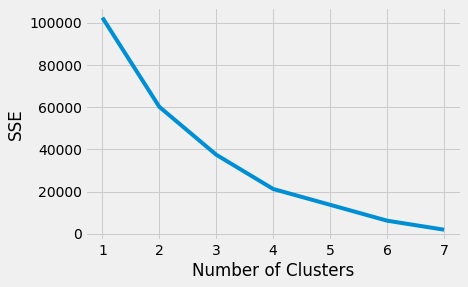

In [106]:
# k值篩選：圖像化篩選結果，SSE肘點為選擇點
plt.style.use("fivethirtyeight")
plt.plot(range(1, 8), sse)
plt.xticks(range(1, 8))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [107]:
# 分組
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(df_dum_detail)
# 將分組資料 (分類標籤) 併入原資料
lb = pd.DataFrame(labels, columns=['labels'])
df_result = pd.concat((lb, df_dum_detail), axis=1)

In [108]:
# 商品類別分類的結果-每組數量
df_result.groupby("labels").count()

,is_cart,category_clean_Apparel,category_clean_Drinkware,category_clean_others
labels,,,,
0,34594,34594,34594,34594
1,68928,68928,68928,68928
2,47220,47220,47220,47220
3,24897,24897,24897,24897


In [109]:
# 商品類別分類的結果-平均值
df_result.groupby("labels").mean()

,is_cart,category_clean_Apparel,category_clean_Drinkware,category_clean_others
labels,,,,
0,1.0,0.349222,0.072151,0.149246
1,0.0,0.000000,0.124536,0.000000
2,0.0,1.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,1.000000


In [209]:
# 設備品牌分類的結果-每組數量
df_result.groupby("labels").count()

,is_cart,device_uni
labels,,
0,26407,26407
1,47432,47432
2,59652,59652
3,42148,42148


In [210]:
# 設備品牌分類的結果-平均值
df_result.groupby("labels").mean()

,is_cart,device_uni
labels,,
0,1.000000,1.43924
1,0.000000,2.00000
2,0.000000,1.00000
3,0.194244,0.00000


In [220]:
# 設備分類的結果-無效
df_result.groupby("labels").mean()

,is_cart,device
labels,,
0,0.197185,0.051924
1,0.196798,2.000000


In [200]:
# 網站進入方式分類的結果 - 無效
df_result.groupby("labels").mean()

,is_cart,medium_(data deleted),medium_(none),medium_<Other>,medium_cpc,medium_organic,medium_referral
labels,,,,,,,
0,0.200059,0.0,0.0,0.0,0.16576,0.0,0.83424
1,0.196028,0.0,1.0,0.0,0.00000,0.0,0.00000
2,0.189574,0.0,0.0,0.0,0.00000,1.0,0.00000
3,0.221813,1.0,0.0,0.0,0.00000,0.0,0.00000
4,0.192397,0.0,0.0,1.0,0.00000,0.0,0.00000


In [166]:
# 國家分類的結果 -無效
df_result.groupby("labels").mean()

,is_cart,country_(not set),country_Albania,country_Algeria,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,...,country_Trinidad & Tobago,country_Tunisia,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Venezuela,country_Vietnam
labels,,,,,,,,,,,,,,,,,,,,,
0,0.196482,0.01325,0.000379,0.001393,0.004403,0.000748,0.016527,0.00553,0.000502,0.000297,...,0.000236,0.00127,0.019169,0.006236,0.004639,0.055469,0.0,0.001434,0.000358,0.007403
1,0.197561,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000


In [ ]:
df_result.groupby("labels").count()

,is_cart,category_clean_Apparel,category_clean_Bag,category_clean_Campus Collection,category_clean_Drinkware,category_clean_Eco-Friendly,category_clean_Google,category_clean_Kids,category_clean_New,category_clean_Notebooks,category_clean_Sale,category_clean_Stationery,category_clean_others
labels,,,,,,,,,,,,,
0,43322,43322,43322,43322,43322,43322,43322,43322,43322,43322,43322,43322,43322
1,25489,25489,25489,25489,25489,25489,25489,25489,25489,25489,25489,25489,25489
2,37483,37483,37483,37483,37483,37483,37483,37483,37483,37483,37483,37483,37483
3,23843,23843,23843,23843,23843,23843,23843,23843,23843,23843,23843,23843,23843


In [ ]:
df_result.groupby("labels").mean()

,is_cart,category_clean_Apparel,category_clean_Bag,category_clean_Campus Collection,category_clean_Drinkware,category_clean_Eco-Friendly,category_clean_Google,category_clean_Kids,category_clean_New,category_clean_Notebooks,category_clean_Sale,category_clean_Stationery,category_clean_others
labels,,,,,,,,,,,,,
0,0.166405,0.000000,0.110960,0.050252,0.097272,0.077882,0.077374,0.046581,0.085130,0.030031,0.350353,0.074166,0.0
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,1.000000,0.457247,0.065443,0.053224,0.094229,0.058160,0.060214,0.045381,0.070459,0.033135,0.000000,0.062508,0.0
3,0.366061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
